### Problem 1
Momentum model with a window of 3 months and a reversal of 1 month.
Long: top decile (equal dollars) and short bottom decile (equal dollars). Equal dollars means that each of the
stocks in the decile is long or short the same amount. Since you have 50 stocks, the top decile will be 5 stocks
and the bottom decile will be 5 stocks.

### Problem 2
Add diversification. Instead of being long the top decile, be long the top half. 25 stocks long and 25 short.

### Problem 3
Back to top and bottom deciles. However, instead of weighting equal dollars, weight each stock in the long and
the short by their volatility over the previous 50 days, so that the long and the short have the same volatility (you
choose some arbitrary number like 5% if you need).

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import datetime as dt
pd.options.display.min_rows=1000
pd.set_option('display.max_rows', 1000)
pd.set_option('display.min_rows', 1000)
pd.set_option('display.expand_frame_repr', True)

import pypfopt
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt.expected_returns import mean_historical_return
from pypfopt import black_litterman, risk_models
from pypfopt.expected_returns import mean_historical_return
from pypfopt import EfficientFrontier
pd.options.display.float_format = '{:,.5f}'.format
from IPython.core.display import display, HTML
display(HTML("<style> .container{width:96% !important;}</style>"))
pd.options.display.max_rows=150
pd.options.display.max_columns=150

In [2]:
def VaR_CVaR_Quantile(data_series,
                      significance_level):
    """Return Value at Risk (VaR) and Conditional Value at Risk (CVaR) at significance_level"""
    import scipy.stats
    import numpy as np
    mean=np.mean(data_series)
    std= np.std(data_series)
    ### Data Driven VaR CVaR
    VaR_Quantile = np.quantile(data_series,significance_level)
    return_in_tail_based_on_VaR_Quantile=data_series[data_series<VaR_Quantile]
    CVaR_Quantile=(np.mean(return_in_tail_based_on_VaR_Quantile))
    return(VaR_Quantile,CVaR_Quantile)

In [3]:
def portfolio_stats_computer(portfolio_return_series,
                            frequency=252):
    """This Function is to compute Annualized Return and Volatility of a series given the series and its frequency
    VaR and CVaR are at 5%"""
    portfolio_return_series= pd.Series(portfolio_return_series)
    cum_return=(1 + portfolio_return_series).prod()
    portfolio_annualized_compouded_return = (1 + portfolio_return_series).prod() ** (frequency / portfolio_return_series.count()) - 1
    portfolio_annualized_simple_return = portfolio_return_series.mean()*frequency
    portfolio_annualized_volatility= portfolio_return_series.std()*np.sqrt(frequency)
    portfolio_VaR_05, portfolio_CVaR_05 = VaR_CVaR_Quantile(portfolio_return_series,0.05)
    portfolio_sharp_ratio = portfolio_annualized_compouded_return/portfolio_annualized_volatility
    
    portfolio_kurtosis= scipy.stats.kurtosis(portfolio_return_series)+3
    portfolio_skewness= scipy.stats.skew(portfolio_return_series)
    
    dict_stats={"Annualized Simple Return":[portfolio_annualized_simple_return],
                "Annualized Compunded Return":[portfolio_annualized_compouded_return],
                "Cumulative Return":[cum_return],
                "Annualized Volatility":[portfolio_annualized_volatility],
                "Sharp Ratio":[portfolio_sharp_ratio],
                "Kurtosis":[portfolio_kurtosis],
                "Skewness":[portfolio_skewness],
                "VaR 5":[portfolio_VaR_05],
                "CVaR 5":[portfolio_CVaR_05]}
    return pd.DataFrame(dict_stats)

In [4]:
def return_calculator(df_stock_prices,
                      return_window=1,
                      dropna=True):
    """apply pct_change(return_window) on the columns of dataframe.
    compute return of stocks"""
    df_data=df_stock_prices.copy()
    if dropna:
        return(df_data.pct_change(return_window).dropna())
    return(df_data.pct_change(return_window))

In [5]:
def date_assets_trade_signal_genarator(df_stock_prices,
                                       return_window=5,
                                       number_of_asset_go_long=2,
                                       number_of_asset_go_short=2):
    """compute the winners (highest return) and loosers (lowest return).
    df_stock_prices: daily stock price. Index must be datetime"""
    df_stock_return_window = return_calculator(df_stock_prices,
                                               return_window)
    df_stock_return_window = pd.melt(df_stock_return_window.reset_index(),
                          var_name="ticker",
                          id_vars="Date",
                          value_name="Return")
    df_stock_return_window=df_stock_return_window.reset_index()

    assset_to_long_index= df_stock_return_window.groupby(["Date"])["Return"].apply(
        lambda x: pd.Series(x.nlargest(number_of_asset_go_long))).index

    assset_to_short_index=df_stock_return_window.groupby(["Date"])["Return"].apply(
        lambda x: pd.Series(x.nsmallest(number_of_asset_go_short))).index

    df_long=df_stock_return_window[df_stock_return_window[['Date','index']].apply(
        tuple, axis = 1).isin(assset_to_long_index)].sort_values("Date")

    df_short=df_stock_return_window[df_stock_return_window[['Date','index']].apply(
        tuple, axis = 1).isin(assset_to_short_index)].sort_values("Date")
    #signal_dates =pd.Series(df_long['Date'].drop_duplicates().values)
    date_asset_to_go_long = pd.Series(df_long[['Date','ticker']].apply(tuple, axis = 1).values)
    date_asset_to_go_short = pd.Series(df_short[['Date','ticker']].apply(tuple, axis = 1).values)
    return ({"date_asset_to_go_long":date_asset_to_go_long,
             "date_asset_to_go_short":date_asset_to_go_short})

In [6]:
def signal_date_determinator(possible_trading_dates,
                             rebalancing_dates,
                             reversal=0):
    """If you want to use the signal to buy/sell, you can use the signals from any day on or before trading day. 
    Given all the possible trading days and reversal (eg 1 day). We take the signals generated (winners and looser) reversal days prior
    from the day making the trade"""
    list_of_signal_dates=[]
    for rebalancing_date in rebalancing_dates:
        signal_date = possible_trading_dates[possible_trading_dates<=rebalancing_date].values[-1-reversal]
        list_of_signal_dates.append(signal_date)
    signal_dates = pd.Series(list_of_signal_dates)
    trading_dates_signal_dates_dict=dict(zip(rebalancing_dates,signal_dates))
    return(trading_dates_signal_dates_dict)

In [7]:
def momentum_trading(df_stock_prices,
                     return_window=5,
                     revesal=0,
                     rebalancing_period=10,
                     number_of_asset_go_long = 2,
                     number_of_asset_go_short = 2):
    """Buy the winners and short the loosers.
    df_stock_prices: daily stock price. Index must be datetime
    return_window: the return to generate buy or short signal.
    revesal: number of lag for buy and sell signal respective to the retrun window.
    number_of_asset_go_long: Number best perfomer asset to go long.
    number_of_asset_go_short: Number worst perfomer asset to go short.
    rebalancing_period: holding period.rebalancing the portfolio."""
    possible_trading_dates= pd.Series(sorted(df_stock_prices.index))
    ### Rebalancing is possible only after signals are generated
    rebalancing_dates = possible_trading_dates[return_window::rebalancing_period]
    rebalancing_dates=pd.Series(rebalancing_dates.values)
    ### Signal Date Generator
    signal_dates=signal_date_determinator(possible_trading_dates=possible_trading_dates,
                                          rebalancing_dates=rebalancing_dates,
                                          reversal=revesal)

    signals = date_assets_trade_signal_genarator(df_stock_prices,
                                                 return_window=return_window,
                                                 number_of_asset_go_long=number_of_asset_go_long,
                                                 number_of_asset_go_short=number_of_asset_go_short)
    
    date_asset_to_go_long = signals["date_asset_to_go_long"]
    date_asset_to_go_short = signals["date_asset_to_go_short"]
    
    df_stock_return_on_rebalncing_bases = return_calculator(df_stock_prices,
                                                          rebalancing_period).reset_index()
    #portfolio_trading_dates = pd.Series(df_stock_return_on_rebalncing_bases["Date"].drop_duplicates().values)
    
    df_stock_return_on_rebalncing_bases = pd.melt(df_stock_return_on_rebalncing_bases,
                                                  id_vars="Date",
                                                  var_name="ticker",
                                                  value_name="Return")
    
    df_stock_return_on_rebalncing_bases=df_stock_return_on_rebalncing_bases[
        df_stock_return_on_rebalncing_bases['Date'].isin(rebalancing_dates)]
    
    #df_stock_return_on_rebalncing_bases["signal_date"]= df_stock_return_on_rebalncing_bases.groupby(['ticker'])["Date"].shift(revesal+1)
    df_stock_return_on_rebalncing_bases["trade_date"]= df_stock_return_on_rebalncing_bases.groupby(['ticker'])["Date"].shift(1)
    df_stock_return_on_rebalncing_bases["signal_date"] = df_stock_return_on_rebalncing_bases["trade_date"].replace(signal_dates)
    df_stock_return_on_rebalncing_bases= df_stock_return_on_rebalncing_bases.sort_values(["Date","ticker"])
    
    df_stock_return_on_rebalncing_bases["Long"] =  df_stock_return_on_rebalncing_bases[['signal_date','ticker']].apply(
        tuple, axis = 1).isin(date_asset_to_go_long)

    df_stock_return_on_rebalncing_bases["Short"] =  df_stock_return_on_rebalncing_bases[['signal_date','ticker']].apply(
        tuple, axis = 1).isin(date_asset_to_go_short)
    df_stock_return_on_rebalncing_bases.dropna(subset=["signal_date"],inplace=True)
    df_stock_return_on_rebalncing_bases.reset_index(drop=True,inplace=True)
    return(df_stock_return_on_rebalncing_bases)

1. 
Momentum model with a window of 3 months and a reversal of 1 month.
Long: top decile (equal dollars) and short bottom decile (equal dollars). Equal dollars means that each of the stocks in the decile is long or short the same amount. Since you have 50 stocks, the top decile will be 5 stocks and the bottom decile will be 5 stocks.

In [8]:
list_of_tickers=list(pd.read_excel('Stock Tickers and Attributes.xlsx')["ticker"])
list_of_tickers=list_of_tickers[1:53]
#list_of_tickers=["SPY","SLY","GLD","FEZ","BABA"]
df_stock_data= yf.download(list_of_tickers,start=dt.datetime(2012,1,15),end=dt.datetime(2020,2,15))
df_stock_data=df_stock_data["Adj Close"]
### If no price is avaialble for all the asset for a given day, dorp that row
df_stock_data.dropna(axis=0,how="all",inplace=True)
### Drop the assets that are not available for the whole period
df_stock_data.dropna(axis=1,inplace=True)

[*********************100%***********************]  52 of 52 completed


1. 
Momentum model with a window of 3 months and a reversal of 1 month.
Long: top decile (equal dollars) and short bottom decile (equal dollars). Equal dollars means that each of the stocks in the decile is long or short the same amount. Since you have 50 stocks, the top decile will be 5 stocks and the bottom decile will be 5 stocks.

In [9]:
holding_period = 21
return_window = 63 
revesal = 21
df_portfolio = momentum_trading(df_stock_data,
                                return_window=return_window,
                                revesal=revesal,
                                rebalancing_period= holding_period,
                                number_of_asset_go_long = 5,
                                number_of_asset_go_short = 5)
df_portfolio.head()

,Date,ticker,Return,trade_date,signal_date,Long,Short
0,2012-05-16,AAPL,-0.10435,2012-04-17,2012-03-16,False,False
1,2012-05-16,ABT,0.03508,2012-04-17,2012-03-16,False,False
2,2012-05-16,ADBE,-0.04374,2012-04-17,2012-03-16,False,False
3,2012-05-16,AMZN,0.18934,2012-04-17,2012-03-16,False,False
4,2012-05-16,BA,-0.01775,2012-04-17,2012-03-16,False,False


In [10]:
df_portfolio_return=df_portfolio[(df_portfolio["Long"]==True) | 
                          (df_portfolio["Short"]==True)].sort_values(
    ["Date","ticker"]).reset_index(drop=True)

df_portfolio_return["Trade Return"]= df_portfolio_return["Return"].copy()
df_portfolio_return.loc[df_portfolio_return['Short']==True,
                "Trade Return"] = df_portfolio_return["Trade Return"]*-1


### Get the weight of each asset equally in the portfolio
df_portfolio_return=pd.merge(df_portfolio_return,(1/ (df_portfolio_return.groupby(["Date"])["Long"].sum() + 
                                                      df_portfolio_return.groupby(["Date"])["Short"].sum())).reset_index(name="weight"),
                             left_on='Date',
                             right_on='Date',
                             how="left")

df_portfolio_return["Realized Return"]= df_portfolio_return["Trade Return"] * df_portfolio_return["weight"]

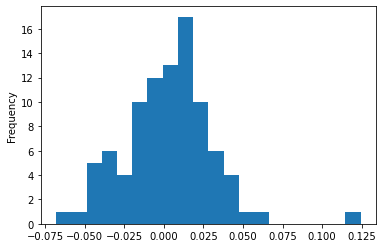

Sum of PNL for $100 on each trade
 25.04366059301023


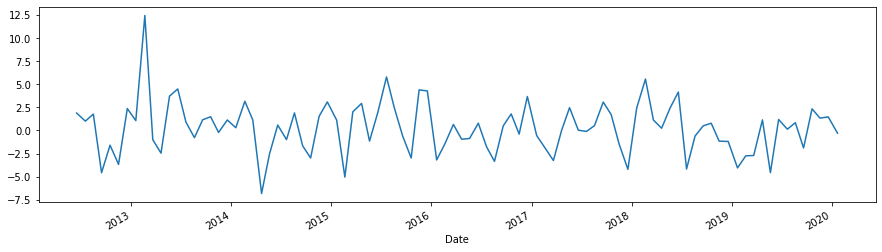

,Annualized Simple Return,Annualized Compunded Return,Cumulative Return,Annualized Volatility,Sharp Ratio,Kurtosis,Skewness,VaR 5,CVaR 5
0,0.03267,0.02840,1.23946,0.09737,0.29164,5.73570,0.61034,-0.04182,-0.05036


In [11]:
portfolio_return = df_portfolio_return.groupby(["Date"])["Realized Return"].sum()
portfolio_return.plot(kind="hist",bins=20)
plt.show()

print("Sum of PNL for $100 on each trade\n",(100*portfolio_return).sum())
(100*portfolio_return).plot(figsize=(15,4))
plt.show()
portfolio_stats_computer(portfolio_return,252/holding_period)

In [27]:
print("Best Month",portfolio_return.sort_values(ascending=False).head(1))
print("Worst Month",portfolio_return.sort_values(ascending=True).head(1))
print("Mean Of Returns",portfolio_return.mean())
print("Std Of Returns",portfolio_return.std())

Best Month Date
2013-02-19   0.12432
Name: Realized Return, dtype: float64
Worst Month Date
2014-04-21   -0.06813
Name: Realized Return, dtype: float64
Mean Of Returns 0.002722137020979373
Std Of Returns 0.028108255227769854


2. 
Add diversification. Instead of being long the top decile, be long the top half. 25 stocks long and 25 short.

In [28]:
holding_period = 21
return_window = 63 
revesal = 21
df_portfolio = momentum_trading(df_stock_data,
                                return_window=return_window,
                                revesal=revesal,
                                rebalancing_period= holding_period,
                                number_of_asset_go_long = 25,
                                number_of_asset_go_short = 25)


df_portfolio_return=df_portfolio[(df_portfolio["Long"]==True) | 
                          (df_portfolio["Short"]==True)].sort_values(
    ["Date","ticker"]).reset_index(drop=True)

df_portfolio_return["Trade Return"]= df_portfolio_return["Return"].copy()
df_portfolio_return.loc[df_portfolio_return['Short']==True,
                "Trade Return"] = df_portfolio_return["Trade Return"]*-1


### Get the weight of each asset equally in the portfolio
df_portfolio_return=pd.merge(df_portfolio_return,(1/ (df_portfolio_return.groupby(["Date"])["Long"].sum() + 
                                                      df_portfolio_return.groupby(["Date"])["Short"].sum())).reset_index(name="weight"),
                             left_on='Date',
                             right_on='Date',
                             how="left")

df_portfolio_return["Realized Return"]=df_portfolio_return["Trade Return"] * df_portfolio_return["weight"]

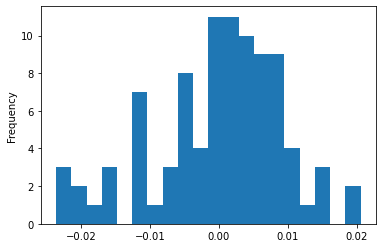

Sum of PNL for $100 on each trade
 -1.5987996806367004


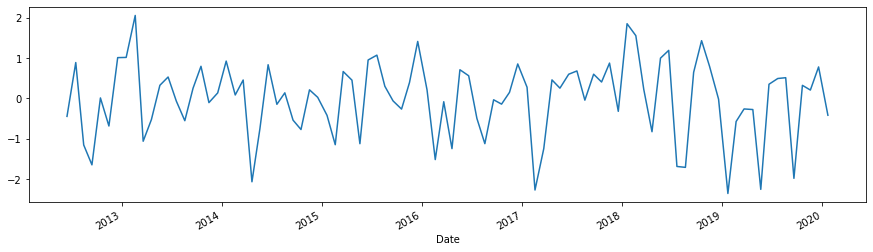

,Annualized Simple Return,Annualized Compunded Return,Cumulative Return,Annualized Volatility,Sharp Ratio,Kurtosis,Skewness,VaR 5,CVaR 5
0,-0.00209,-0.00261,0.98017,0.03259,-0.08007,3.03669,-0.54811,-0.01832,-0.02186


In [29]:
portfolio_return = df_portfolio_return.groupby(["Date"])["Realized Return"].sum()
portfolio_return.plot(kind="hist",bins=20)
plt.show()

print("Sum of PNL for $100 on each trade\n",(100*portfolio_return).sum())
(100*portfolio_return).plot(figsize=(15,4))
plt.show()
portfolio_stats_computer(portfolio_return,252/holding_period)

In [30]:
print("Best Month",portfolio_return.sort_values(ascending=False).head(1))
print("Worst Month",portfolio_return.sort_values(ascending=True).head(1))
print("Mean Of Returns",portfolio_return.mean())
print("Std Of Returns",portfolio_return.std())

Best Month Date
2013-02-19   0.02053
Name: Realized Return, dtype: float64
Worst Month Date
2019-01-22   -0.02356
Name: Realized Return, dtype: float64
Mean Of Returns -0.0001737825739822496
Std Of Returns 0.0094078081921413


3. 
Back to top and bottom deciles. However, instead of weighting equal dollars, weight each stock in the long and the short by their volatility over the previous 50 days, so that the long and the short have the same volatility (you choose some arbitrary number like 5% if you need).

In [31]:
from scipy.optimize import minimize

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol 


def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

In [32]:
### Compute 50 day rolling COV matrix
df_rolling_cov = return_calculator(df_stock_data).rolling(50).cov().dropna()

In [33]:
### Compute returns of the strategy
holding_period= 21
return_window = 63 
revesal = 21
df_portfolio = momentum_trading(df_stock_data,
                                return_window=return_window,
                                revesal=revesal,
                                rebalancing_period= holding_period,
                                number_of_asset_go_long = 5,
                                number_of_asset_go_short = 5)

df_portfolio_return=df_portfolio[(df_portfolio["Long"]==True) | 
                          (df_portfolio["Short"]==True)].sort_values(
    ["Date","ticker"]).reset_index(drop=True)

df_portfolio_return["Trade Return"]= df_portfolio_return["Return"].copy()
df_portfolio_return.loc[df_portfolio_return['Short']==True,
                "Trade Return"] = df_portfolio_return["Trade Return"]*-1


list_of_trading_days= sorted(list(set(df_portfolio_return["trade_date"])))

### Get the weights which would result in equal risk contribution form each asset

In [34]:
list_of_asset_weights_for_eqaul_risk_on_traindg_date= []
for trading_date in list_of_trading_days:
    df_portfolio_return_sub = df_portfolio_return[df_portfolio_return['trade_date']==trading_date]

    df_rolling_cov_sub = df_rolling_cov[df_rolling_cov.index.isin(tuple(zip(df_portfolio_return_sub["Date"],
                                                                            df_portfolio_return_sub["ticker"])))][
        list(df_portfolio_return_sub["ticker"])]

    df_equal_risk_on_trading_date=pd.DataFrame({"ticker":df_rolling_cov_sub.columns,
                                                "weight":equal_risk_contributions(df_rolling_cov_sub)})
    df_equal_risk_on_trading_date["trade_date"] = trading_date
    list_of_asset_weights_for_eqaul_risk_on_traindg_date.append(df_equal_risk_on_trading_date)
    
df_equal_risk_on_trading_date=pd.concat(list_of_asset_weights_for_eqaul_risk_on_traindg_date,
                                        ignore_index=True)
### Merge the weights with equal risk contribution 
df_portfolio_return=pd.merge(df_portfolio_return,
                     df_equal_risk_on_trading_date,
                     left_on=["ticker","trade_date"],
                     right_on=["ticker","trade_date"],
                     how="left")

In [35]:
df_portfolio_return.head()

,Date,ticker,Return,trade_date,signal_date,Long,Short,Trade Return,weight
0,2012-06-15,AAPL,0.05137,2012-05-16,2012-04-17,True,False,0.05137,0.07250
1,2012-06-15,BAC,0.11261,2012-05-16,2012-04-17,True,False,0.11261,0.04656
2,2012-06-15,CRM,-0.01479,2012-05-16,2012-04-17,True,False,-0.01479,0.06957
3,2012-06-15,CVX,0.04226,2012-05-16,2012-04-17,False,True,-0.04226,0.09867
4,2012-06-15,GOOG,-0.10243,2012-05-16,2012-04-17,False,True,0.10243,0.11058


In [36]:
df_portfolio_return["Realized Return"]=df_portfolio_return["Trade Return"] * df_portfolio_return["weight"]

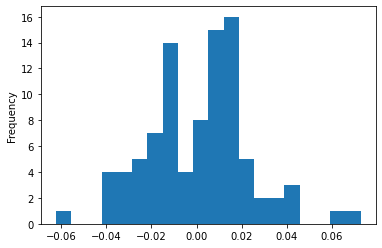

Sum of PNL for $100 on each trade
 14.391835643053554


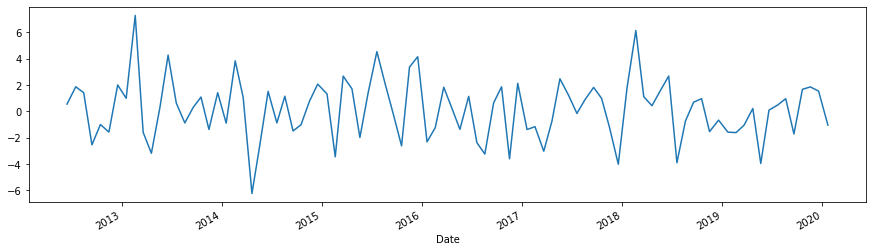

,Annualized Simple Return,Annualized Compunded Return,Cumulative Return,Annualized Volatility,Sharp Ratio,Kurtosis,Skewness,VaR 5,CVaR 5
0,0.01877,0.01580,1.12770,0.07912,0.19969,3.63443,0.15196,-0.03513,-0.04337


In [37]:
portfolio_return = df_portfolio_return.groupby(["Date"])["Realized Return"].sum()
portfolio_return.plot(kind="hist",bins=20)
plt.show()

print("Sum of PNL for $100 on each trade\n",(100*portfolio_return).sum())
(100*portfolio_return).plot(figsize=(15,4))
plt.show()
portfolio_stats_computer(portfolio_return,252/holding_period)

In [39]:
print("Best Month",portfolio_return.sort_values(ascending=False).head(1))
print("Worst Month",portfolio_return.sort_values(ascending=True).head(1))
print("Mean Of Returns",portfolio_return.mean())
print("Std Of Returns",portfolio_return.std())

Best Month Date
2013-02-19   0.07277
Name: Realized Return, dtype: float64
Worst Month Date
2014-04-21   -0.06228
Name: Realized Return, dtype: float64
Mean Of Returns 0.0015643299612014736
Std Of Returns 0.022839166882609858
